In [1]:
# -------------------------------------------------------------------------------
# Name: main.py
# Purpose: Pull data from twitter, perform sentiment analysis and pull stock data
#
# Author(s):    David Little
#
# Created:      04/26/2021
# Updated:
# Update Comment(s):
#
# TO DO:
#
# -------------------------------------------------------------------------------


import requests
import pandas as pd
import time
import regex as re
from datetime import datetime, timedelta

In [3]:
def get_data(tweet):
    data = {
        'id': tweet['id'],
        'created_at': tweet['created_at'],
        'text': tweet['text'],
        'retweet_count': tweet['public_metrics']['retweet_count'],
        'like_count': tweet['public_metrics']['like_count'],
        'reply_count': tweet['public_metrics']['reply_count']
#        'quote_count': tweet['public_metrics']['quote_count']
    }
    return data

In [4]:
whitespace = re.compile(r"\s+")
web_address = re.compile(r"(?i)http(s):\/\/[a-z0-9.~_\-\/]+")
tesla = re.compile(r"(?i)@Tesla(?=\b)")
user = re.compile(r"(?i)@[a-z0-9_]+")

In [5]:
#------------------------------------- Twitter Pull  --------------------------------------------------------

# setup the API request
endpoint = 'https://api.twitter.com/2/tweets/search/recent'  # 'https://api.twitter.com/2/tweets/search/all'
headers = {'authorization': f'Bearer {BEARER_TOKEN}'}
params = {
    'query': '(tesla OR tsla OR elon musk and -spacex -is:retweet) (lang:en)', # 
    'max_results': '100',
    'tweet.fields': 'created_at,lang,public_metrics'
        }

In [6]:
dtformat = '%Y-%m-%dT%H:%M:%SZ'  # the date format string required by twitter

# we use this function to subtract 60 mins from our datetime string
def time_travel(now, mins):
    now = datetime.strptime(now, dtformat)
    back_in_time = now - timedelta(minutes=mins)
    return back_in_time.strftime(dtformat)

In [7]:
now = datetime.now()  # get the current datetime, this is our starting point
last_week = now - timedelta(days=6)  # datetime one week ago = the finish line
now = now.strftime(dtformat)  # convert now datetime to format for API
now

'2021-11-02T11:12:06Z'

In [8]:
df = pd.DataFrame()  # initialize dataframe to store tweets
while True:
    if datetime.strptime(now, dtformat) < last_week:
        # if we have reached 6 days ago, break the loop
        break
    pre60 = time_travel(now, 5)  # get x minutes before 'now'
    # assign from and to datetime parameters for the API
    params['start_time'] = pre60
    params['end_time'] = now
    response = requests.get(endpoint,
                            params=params,
                            headers=headers)  # send the request
    time.sleep(2)
    now = pre60  # move the window 60 minutes earlier
    # iteratively append our tweet data to our dataframe
    for tweet in response.json()['data']:
        row = get_data(tweet)  # we defined this function earlier
        if row['like_count']>=0 and row['retweet_count']>=0 and row['reply_count']>=0:   #row['like_count'] >=3:
            df = df.append(row, ignore_index=True)
df

,created_at,id,like_count,reply_count,retweet_count,text
0,2021-11-02T11:12:05.000Z,1455492908941934598,0.0,0.0,29.0,"RT @CNBC: Tesla recalling nearly 12,000 U.S. v..."
1,2021-11-02T11:12:05.000Z,1455492905993375752,0.0,0.0,116.0,RT @realMeetKevin: This is bullish. Contract f...
2,2021-11-02T11:12:04.000Z,1455492901891416064,1.0,0.0,0.0,@elonmusk You do not want to say anything abou...
3,2021-11-02T11:12:04.000Z,1455492901635506177,0.0,0.0,63.0,RT @PITBULLHODL: Soon everybody will talk abou...
4,2021-11-02T11:11:59.000Z,1455492880538144775,0.0,0.0,172.0,"RT @zerohedge: TESLA RECALLING 11,700 U.S. VEH..."
...,...,...,...,...,...,...
171803,2021-10-27T11:15:28.000Z,1453319430730129417,0.0,0.0,168.0,"RT @zerohedge: HERTZ SIGNS DEALS WITH UBER, CA..."
171804,2021-10-27T11:15:25.000Z,1453319419510370306,0.0,0.0,9591.0,RT @lindyli: Elon Musk is attacking Biden over...
171805,2021-10-27T11:15:25.000Z,1453319418453368842,0.0,0.0,1.0,RT @Codeofsilence9: @TheTrollercoin\n\nFather ...
171806,2021-10-27T11:15:25.000Z,1453319417161527300,0.0,0.0,9591.0,RT @lindyli: Elon Musk is attacking Biden over...


In [9]:
#---------------------------------------------- Sentiment Model ------------------------------------------------------

#import flair #lstm model
#sentiment_model = flair.models.TextClassifier.load('en-sentiment')

from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

def is_positive(tweet: str) -> bool:
    """True if tweet has positive compound sentiment, False otherwise."""
    return sia.polarity_scores(tweet)["compound"] > 0

# we will append probability and sentiment preds later
probs = []
sentiments = []
clean_tweets = []
timestamp = []
binary = []

for time in df['created_at']:
    timestamp.append(((datetime.strptime(time, '%Y-%m-%dT%H:%M:%S.%fZ')
                      - timedelta(hours = 4)) #timezone
                      + timedelta(hours = 0) #delay
                     ).strftime('%Y-%m-%d')) # %H:00:00'))

for tweet in df['text']:
# we then use the sub method to replace anything matching
    tweet = whitespace.sub(' ', tweet)
    tweet = web_address.sub('', tweet)
    tweet = tesla.sub('Tesla', tweet)
    tweet = user.sub('', tweet)
    if is_positive(tweet): binary.append(1)
    else: binary.append(0)
    #sentence = flair.data.Sentence(tweet)
    #sentiment_model.predict(sentence)
    # extract sentiment prediction
    #sentiments.append(sentence.labels[0].value)  # 'POSITIVE' or 'NEGATIVE'
    #if sentence.labels[0].value == 'NEGATIVE':
    #    probs.append(-1 * sentence.labels[0].score)  # numerical score 0-1
    #    binary.append(0)
    #else:
    #    probs.append(sentence.labels[0].score)  # numerical score 0-1
     #   binary.append(1)
    clean_tweets.append(tweet)
    # print(tweet)
    # print(' ')

# add probability and sentiment predictions to tweets dataframe
df['text_clean'] = clean_tweets
#df['probability'] = probs
#df['sentiment'] = sentiments
df['binary'] = binary
df['Date'] = timestamp
#df['Date'] = pd.to_datetime(df['Date'])
df

,created_at,id,like_count,reply_count,retweet_count,text,text_clean,binary,Date
0,2021-11-02T11:12:05.000Z,1455492908941934598,0.0,0.0,29.0,"RT @CNBC: Tesla recalling nearly 12,000 U.S. v...","RT : Tesla recalling nearly 12,000 U.S. vehicl...",0,2021-11-02
1,2021-11-02T11:12:05.000Z,1455492905993375752,0.0,0.0,116.0,RT @realMeetKevin: This is bullish. Contract f...,RT : This is bullish. Contract for 100k doesn’...,1,2021-11-02
2,2021-11-02T11:12:04.000Z,1455492901891416064,1.0,0.0,0.0,@elonmusk You do not want to say anything abou...,You do not want to say anything about the tes...,0,2021-11-02
3,2021-11-02T11:12:04.000Z,1455492901635506177,0.0,0.0,63.0,RT @PITBULLHODL: Soon everybody will talk abou...,RT : Soon everybody will talk about us and few...,0,2021-11-02
4,2021-11-02T11:11:59.000Z,1455492880538144775,0.0,0.0,172.0,"RT @zerohedge: TESLA RECALLING 11,700 U.S. VEH...","RT : TESLA RECALLING 11,700 U.S. VEHICLES BECA...",0,2021-11-02
...,...,...,...,...,...,...,...,...,...
171803,2021-10-27T11:15:28.000Z,1453319430730129417,0.0,0.0,168.0,"RT @zerohedge: HERTZ SIGNS DEALS WITH UBER, CA...","RT : HERTZ SIGNS DEALS WITH UBER, CARVANA IN N...",0,2021-10-27
171804,2021-10-27T11:15:25.000Z,1453319419510370306,0.0,0.0,9591.0,RT @lindyli: Elon Musk is attacking Biden over...,RT : Elon Musk is attacking Biden over his pro...,0,2021-10-27
171805,2021-10-27T11:15:25.000Z,1453319418453368842,0.0,0.0,1.0,RT @Codeofsilence9: @TheTrollercoin\n\nFather ...,RT : Father of all meme coins with real utili...,1,2021-10-27
171806,2021-10-27T11:15:25.000Z,1453319417161527300,0.0,0.0,9591.0,RT @lindyli: Elon Musk is attacking Biden over...,RT : Elon Musk is attacking Biden over his pro...,0,2021-10-27


In [10]:
df.to_csv("TwitterData_latest.csv")

In [11]:
#________________________________ Stock Data __________________________________________________________________

import yfinance as yf

#tsla = yf.Ticker("TSLA")
tsla = yf.download( "TSLA",
    start=datetime.strptime(df['created_at'].min(),'%Y-%m-%dT%H:%M:%S.%fZ').strftime('%Y-%m-%d'),
    end=(datetime.strptime(df['created_at'].max(),'%Y-%m-%dT%H:%M:%S.%fZ')+timedelta(days = 2)).strftime('%Y-%m-%d'),
    interval='1d' #'60m'
        )#.reset_index()
tsla_stock = tsla.pct_change().reset_index()

[*********************100%***********************]  1 of 1 completed


In [12]:
converted = []
for time in tsla_stock['Date']:
    converted.append(time.strftime('%Y-%m-%d')) #  %H:00:00'))
tsla_stock['Date'] = converted
#tsla_stock['Date'] = pd.to_datetime(tsla_stock['Date'])
tsla_stock

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-10-27,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-10-28,0.027557,0.009450,0.022721,0.037751,0.037751,-0.293650
2,2021-10-29,0.012684,0.031647,0.018033,0.034316,0.034316,0.099408
3,2021-11-01,0.058362,0.084773,0.042350,0.084910,0.084910,0.873386
4,2021-11-02,0.012537,-0.000967,0.024440,-0.030300,-0.030300,-0.245789


In [13]:
means = df.groupby(['Date'],  as_index=False).mean()
means

,Date,like_count,reply_count,retweet_count,binary
0,2021-10-27,5.167868,0.468168,1268.677978,0.536136
1,2021-10-28,4.180677,0.329441,824.094442,0.516746
2,2021-10-29,6.543851,0.601913,429.850861,0.495043
3,2021-10-30,4.560589,0.436927,625.681103,0.532743
4,2021-10-31,15.175878,0.767453,11519.879532,0.395490
5,2021-11-01,4.083496,0.431812,8115.006227,0.477561
6,2021-11-02,1.110854,0.149658,4551.813275,0.531681


In [14]:
means['Date']

0    2021-10-27
1    2021-10-28
2    2021-10-29
3    2021-10-30
4    2021-10-31
5    2021-11-01
6    2021-11-02
Name: Date, dtype: object

In [15]:
tsla_stock['Date']

0    2021-10-27
1    2021-10-28
2    2021-10-29
3    2021-11-01
4    2021-11-02
Name: Date, dtype: object

In [16]:
combined = means.merge(tsla_stock, how='inner')
combined

,Date,like_count,reply_count,retweet_count,binary,Open,High,Low,Close,Adj Close,Volume
0,2021-10-27,5.167868,0.468168,1268.677978,0.536136,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-10-28,4.180677,0.329441,824.094442,0.516746,0.027557,0.009450,0.022721,0.037751,0.037751,-0.293650
2,2021-10-29,6.543851,0.601913,429.850861,0.495043,0.012684,0.031647,0.018033,0.034316,0.034316,0.099408
3,2021-11-01,4.083496,0.431812,8115.006227,0.477561,0.058362,0.084773,0.042350,0.084910,0.084910,0.873386
4,2021-11-02,1.110854,0.149658,4551.813275,0.531681,0.012537,-0.000967,0.024440,-0.030300,-0.030300,-0.245789


In [17]:
#combined['like_count'].corr(combined['Close'])
combined['binary'].corr(combined['Close'])

-0.9077154005245206

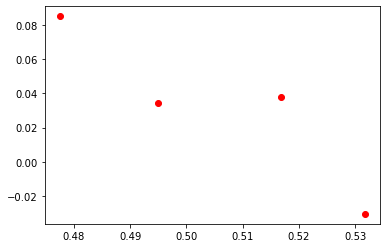

In [18]:
import numpy as np
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1)

# plot the data
ax.plot(combined['binary'],combined['Close'], 'ro')

In [19]:
#import tweepy

#auth = tweepy.OAuthHandler(API_KEY, API_SECRET)
#auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

#api = tweepy.API(auth)

#public_tweets = api.home_timeline()
#for tweet in public_tweets:
#    print(tweet.text)